In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates
from time import time

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# For Arima
import statsmodels.api as sm
import itertools
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import stats
import scipy.io
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# this is for setting the precision to 4, so the data is better distributed on screen
# and the maximum number of columns to display
pd.set_option('max_columns',40, 'precision',4)

In [2]:
column_names_dates = ['Timestamp', 'Module', 'Type', 'month',
       'year', 'day', 'week', 'hour', 'Temp_Mod', 'VBus', 'PT100(0)',
       'PT100(1)', 'LVL_Dim(1)', 'V_MPPT', 'V_Panel', 'LVL_Drain(1)', 'VBat',
       'V_Supp', 'Temp_Oil', 'Temp_gab', 'V_MPPT_TE', 'V_Panel_TE']

In [3]:
# Load dataset with dates
df = pd.read_csv('Features_Dates.csv', usecols=column_names_dates, parse_dates=['Timestamp'])
df['daylight'] = ((df['hour'] >= 7) & (df['hour'] <= 22)).astype(int)
#df['time_epoch'] = (df['Timestamp'].astype(np.int64)/100000000000).astype(np.int64)
# look to the datafram format

In [4]:
data = df.loc[df['Module']=='00.57.FE.0E']
data.head()

,Timestamp,Module,Type,month,year,day,week,hour,Temp_Mod,VBus,PT100(0),PT100(1),LVL_Dim(1),V_MPPT,V_Panel,LVL_Drain(1),VBat,V_Supp,Temp_Oil,Temp_gab,V_MPPT_TE,V_Panel_TE,daylight
2880,2017-10-01 00:00:34,00.57.FE.0E,Radio-2.4 GHz,10,2017,1,39,0,20.1,3.296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2881,2017-10-01 00:02:34,00.57.FE.0E,Radio-2.4 GHz,10,2017,1,39,0,19.9,3.296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2882,2017-10-01 00:04:30,00.57.FE.0E,Radio-2.4 GHz,10,2017,1,39,0,19.9,3.296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2883,2017-10-01 00:06:30,00.57.FE.0E,Radio-2.4 GHz,10,2017,1,39,0,19.9,3.296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2884,2017-10-01 00:08:30,00.57.FE.0E,Radio-2.4 GHz,10,2017,1,39,0,20.1,3.296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# ARIMA Time Series Model

The ARIMA Time Series Model is one of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **A**utoregRessive **I**ntegrated **M**oving **A**verage. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series. 

There are three distinct integers `(p, d, q)` that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

- `p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- `d` is the integrated part of the model. The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0. The purpose of differencing it to make the time series stationary.
- `q` is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

The methods i will employ will only take in data from a uni-variate time series. That means we really are only considering the relationship between the y-axis value the x-axis time points.

## Load and Resample the data to define a frequency and set Timestamp as Index

We first want to visualize the data to understand what type of model we should use. 
- Is there an overall trend in your data that you should be aware of? 
- Does the data show any seasonal trends? 

This is important when deciding which type of model to use. If there isn’t a seasonal trend in your data, then you can just use a regular ARIMA model instead. If you are using daily data for your time series and there is too much variation in the data to determine the trends, you might want to look at resampling your data by month, or looking at the rolling mean.

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
#data = slices[1][slices[1].columns[:9]]
data.set_index('Timestamp', inplace=True, drop=True)
# Take all the data from 2018-10. We don't need to use all the data

In [191]:
data = data['2019-01':'2019-04']
# Resample to 5 min
resampled_data = data.resample('120Min').mean()
# Method Backward Fill
resampled_bfilled_data = resampled_data.fillna(resampled_data.bfill())
# Forward filled data
resampled_ffilled_data = resampled_data.fillna(resampled_data.ffill())

In [192]:
resampled_data.shape

(1440, 20)

It is very useful to have the date as index. This allows to indexing the data using specific dates, which is very comfortable when working with time series.

When resampling the data some missing data can appear, this data can be filled with the mean or more advanced methods.

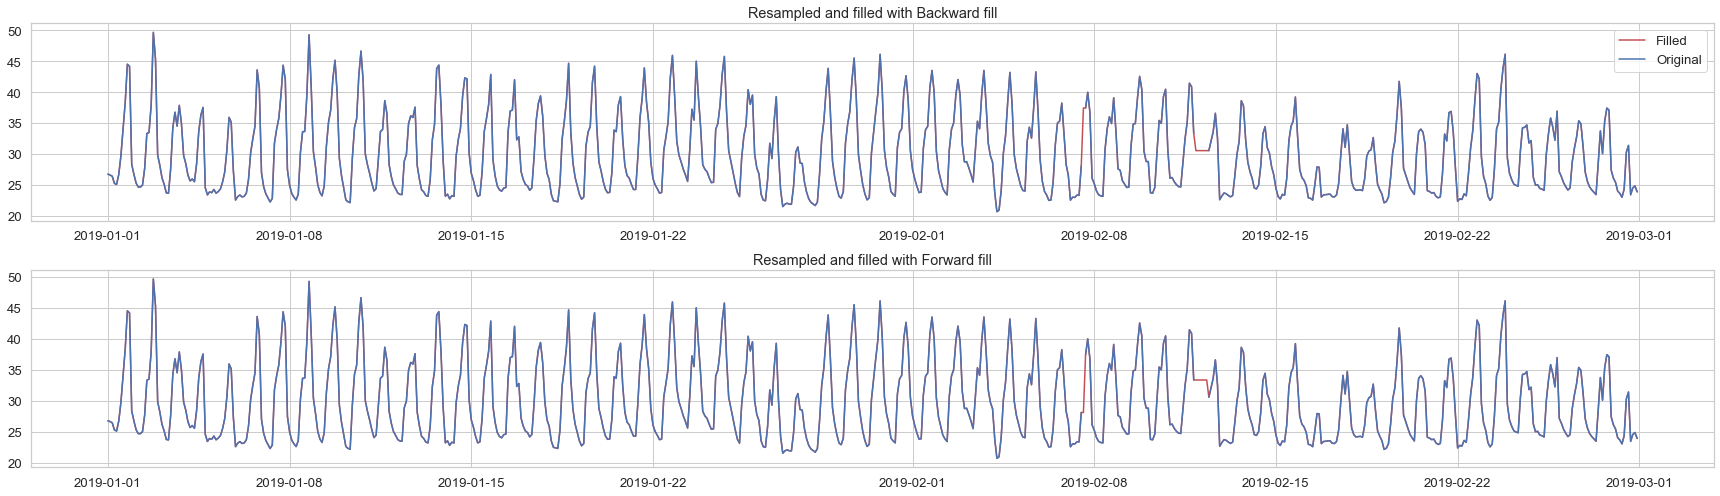

In [193]:
fig, axx = plt.subplots(2, 1, figsize=(24,7))
axx[0].plot(resampled_bfilled_data['2019-01':'2019-02']['Temp_Mod'], color='r', label='Filled')
axx[0].plot(resampled_data['2019-01':'2019-02']['Temp_Mod'], label='Original')
axx[0].set_title('Resampled and filled with Backward fill'); axx[0].legend()
axx[1].plot(resampled_ffilled_data['2019-01':'2019-02']['Temp_Mod'], color='r', label='Filled')
axx[1].plot(resampled_data['2019-01':'2019-02']['Temp_Mod'], label='Original')
axx[1].set_title('Resampled and filled with Forward fill')
plt.tight_layout()

I'm going to select the Backward fill method.

Some distinguishable patterns appear when we zoom the data. The time series has a **seasonality pattern, that we can sey is weekley or daily.**

There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

## Parameter Selection for the ARIMA Time Series Model

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as `ARIMA(p,d,q)(P,D,Q)s` or SARIMA. Here, `(p, d, q)` are the non-seasonal parameters described above, while `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. The term `s `is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

One simple approach is to perform a grid search over multiple values of `p,d,q,P,D,and Q` using some sort of performance criteria. The Akaike information criterion `(AIC)` is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.
The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

The auto_arima function itself operates a bit like a grid search, in that it tries various sets of p and q (also P and Q for seasonal models) parameters, selecting the model that minimizes the AIC (or BIC, or whatever information criterion you select). To select the differencing terms, auto_arima uses a test of stationarity (such as an augmented Dickey-Fuller test) and seasonality (such as the Canova-Hansen test) for seasonal models.
The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:

- 7 - daily
- 12 - monthly
- 52 - weekly

In [239]:
stepwise_model = sm.tsa.statespace.SARIMAX(resampled_bfilled_data['Temp_Mod'],
                                           order=(1, 1, 2),
                                           seasonal_order=(1, 1, 2, 12),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False,
                                           trend=None)

results = stepwise_model.fit(verbose=True)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Temp_Mod   No. Observations:                 1440
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -3092.103
Date:                            Sat, 13 Jun 2020   AIC                           6198.207
Time:                                    13:30:12   BIC                           6234.917
Sample:                                01-01-2019   HQIC                          6211.930
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5384      0.038     14.100      0.000       0.464       0.613
ma.L1         -0.8569      0.044   

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The **P>|z|** column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

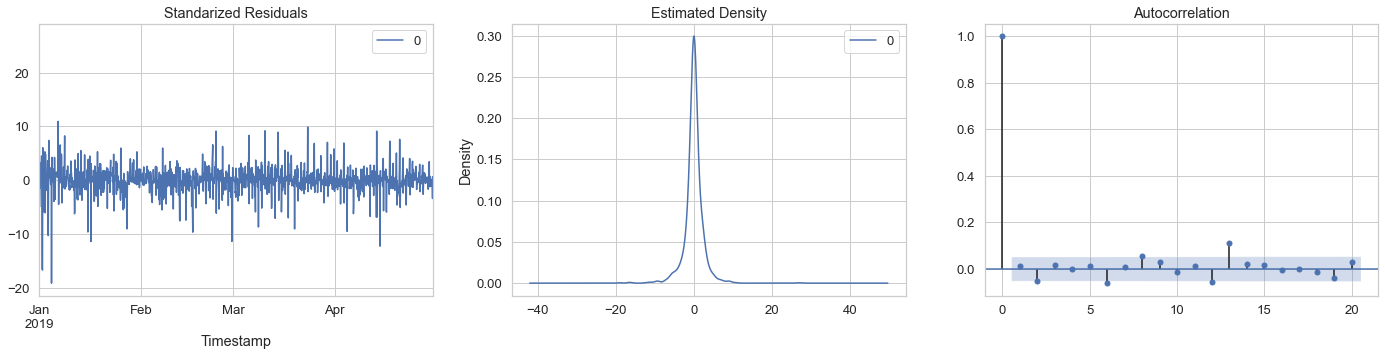

In [240]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,3, figsize=(24,5))
residuals.plot(title="Standarized Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Estimated Density', ax=ax[1])
plot_acf(residuals, ax=ax[2], lags=20)
plt.show()
#results.plot_diagnostics(figsize=(18, 8))
#plt.show()

In [241]:
residuals.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1440.0,0.0161,2.4574,-19.0696,-0.7209,0.045,0.872,26.7633


Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved. The residual errors seem fine with near zero mean and uniform variance.

Also the residuals over time don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot, which shows that the time series residuals have low correlation with lagged versions of itself.

### Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [242]:
y = resampled_bfilled_data['Temp_Mod']

In [243]:
pred = results.get_prediction(start=pd.to_datetime('2019-03-01'), dynamic=False)
pred_ci = pred.conf_int()

The `dynamic=False` argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

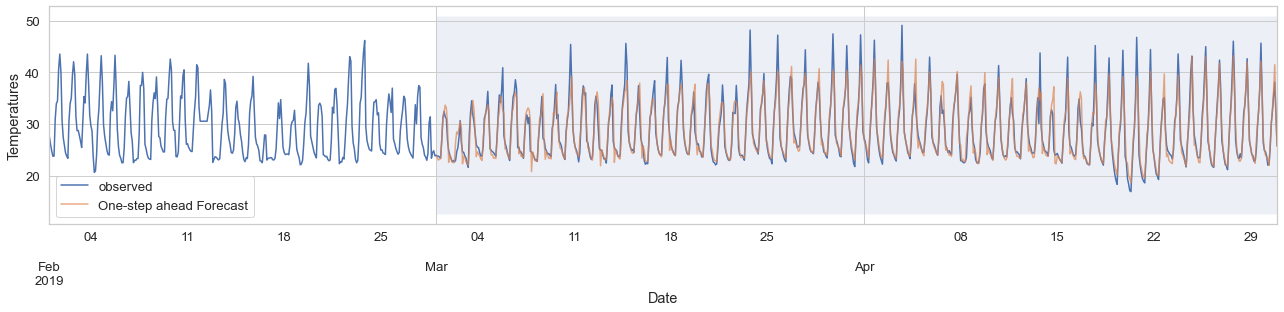

In [244]:
plt.figure(figsize=(22,4))
ax = y['2019-02':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-03-01'), y['2019-02':].index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Temperatures')
plt.legend()

plt.show()

Overall, our forecasts align with the true values very well. It is also useful to quantify the accuracy of our forecasts. We will use the **MSE (Mean Squared Error)**, which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [245]:
forecasted = pred.predicted_mean
y_truth = y['2019-04-01':]

# Compute the mean square error
mse = ((forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4.2


In [246]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=1000)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

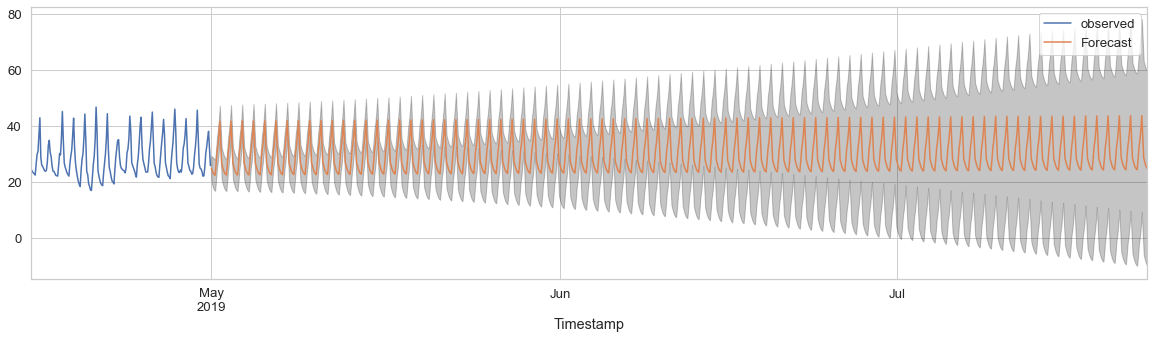

In [247]:
ax = y['2019-04-15':].plot(label='observed', figsize=(20, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.legend()
plt.show()